# ⚙️ 1. Hiperparametreler ve Kütüphane Kurulumu

Bu bölümde, derin öğrenme modelinin eğitim sürecini yönetecek temel yapı taşları ve sabitler tanımlanmaktadır. Stil transferinin başarısı, buradaki CONTENT_WEIGHT (İçerik Ağırlığı) ve STYLE_WEIGHT (Stil Ağırlığı) arasındaki dengeye bağlıdır.

**-EPOCHS:** Veri setinin model üzerinden kaç kez geçeceği.

**-BATCH_SIZE:** Her bir adımda kaç resmin aynı anda işleneceği.

**-LEARNING_RATE:** Modelin hatalarından ne kadar hızlı ders çıkaracağı (Adım büyüklüğü).

**-DEVICE:** Eğitimin GPU (CUDA) üzerinde yapılarak hızlandırılması sağlanır.

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms, models

# --- 1. AYARLAR (HİPERPARAMETRELER) ---
EPOCHS = 2
BATCH_SIZE = 4
LEARNING_RATE = 1e-4
CONTENT_WEIGHT = 1e4    # İçeriği koruma gücü
STYLE_WEIGHT = 1e10     # Stili basma gücü
TV_WEIGHT = 1e-4        # Pürüzsüzleştirme (Gürültü azaltma)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"✅ Kurulum Tamamlandı. Çalışma Cihazı: {DEVICE}")

✅ Kurulum Tamamlandı. Çalışma Cihazı: cuda


# 📂 2. Veri Seti Hazırlığı (COCO Dataset)

Modelin "içeriği" (nesneleri, şekilleri, derinliği) tanıması için Microsoft COCO (Common Objects in Context) veri setinin val2017 bölümü kullanılmaktadır.

**-Neden COCO?** Modelin sadece tek bir resmi değil, her türlü fotoğrafı (insan, manzara, şehir) dönüştürebilmesi için geniş ve çeşitli bir veri setine ihtiyaç vardır.

**-Ön İşleme (Transforms):** Görüntüler 256x256 boyutuna getirilip tensör formatına çevrilir.

**-Lazy Loading:** RAM belleğini şişirmemek için resimler topluca hafızaya yüklenmez, eğitim sırası geldikçe diskten okunur.

In [3]:
# --- 2. VERİ SETİ İNDİRME VE HAZIRLAMA ---
if not os.path.exists("val2017"):
    print("📥 Veri seti indiriliyor (1GB)...")
    os.system("wget -q http://images.cocodataset.org/zips/val2017.zip")
    os.system("unzip -q val2017.zip")
    print("✅ Veri seti indirildi ve zipten çıkarıldı.")
else:
    print("✅ Veri seti zaten mevcut.")

# Transform İşlemleri
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor() # 0-1 Aralığı
])

# Lazy Dataset Sınıfı (Hafıza Dostu)
class LazyDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.files = [f for f in os.listdir(root) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        try:
            img_path = os.path.join(self.root, self.files[idx])
            img = Image.open(img_path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            return img, 0
        except:
            return torch.zeros(3, 256, 256), 0

# Loader Oluşturma
dataset = LazyDataset("val2017", transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"✅ Veri Yükleyici Hazır: {len(dataset)} resim ile eğitim yapılacak.")

✅ Veri seti zaten mevcut.
✅ Veri Yükleyici Hazır: 5000 resim ile eğitim yapılacak.


# 🧠 3. Model Mimarisi (TransformerNet & VGG16)

Bu projede iki farklı sinir ağı birlikte çalışmaktadır:

**1-)TransformerNet (Ressam):** Görüntüyü alıp stilize eden asıl ağdır. Encoder-Decoder yapısındadır ve Residual Block'lar sayesinde görüntüdeki detayları kaybetmeden stili uygular.

**2-)VGG16 (Eleştirmen):** Önceden eğitilmiş (Pre-trained) bir ağdır. Görüntüyü değiştirmez, sadece "loss" (hata) hesaplamak için kullanılır. Modelin ürettiği resmin stil ve içerik açısından ne kadar başarılı olduğunu matematiksel olarak ölçer.

**Not:** VGG16'nın ağırlıkları dondurulmuştur (frozen), eğitim sırasında güncellenmez.

In [4]:
# --- 3. MODEL MİMARİSİ (Artifact-Free) ---

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.in1 = nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.in2 = nn.InstanceNorm2d(channels, affine=True)
        self.relu = nn.ReLU()
    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        return out + residual

class TransformerNet(nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 32, kernel_size=9, stride=1, padding=4)
        self.in1 = nn.InstanceNorm2d(32, affine=True)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.in2 = nn.InstanceNorm2d(64, affine=True)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.in3 = nn.InstanceNorm2d(128, affine=True)

        # Residuals
        self.res_blocks = nn.Sequential(
            ResidualBlock(128), ResidualBlock(128), ResidualBlock(128),
            ResidualBlock(128), ResidualBlock(128)
        )

        # Decoder (Upsample + Conv)
        self.deconv1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.deconv1_conv = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.in4 = nn.InstanceNorm2d(64, affine=True)

        self.deconv2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.deconv2_conv = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.in5 = nn.InstanceNorm2d(32, affine=True)

        self.deconv3 = nn.Conv2d(32, 3, kernel_size=9, stride=1, padding=4)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.in1(self.conv1(x)))
        out = self.relu(self.in2(self.conv2(out)))
        out = self.relu(self.in3(self.conv3(out)))
        out = self.res_blocks(out)
        out = self.relu(self.in4(self.deconv1_conv(self.deconv1(out))))
        out = self.relu(self.in5(self.deconv2_conv(self.deconv2(out))))
        out = self.deconv3(out)
        return out

class Vgg16(nn.Module):
    def __init__(self):
        super(Vgg16, self).__init__()
        vgg = models.vgg16(pretrained=True).features
        self.slice1 = nn.Sequential()
        self.slice2 = nn.Sequential()
        self.slice3 = nn.Sequential()
        self.slice4 = nn.Sequential()
        for x in range(4): self.slice1.add_module(str(x), vgg[x])
        for x in range(4, 9): self.slice2.add_module(str(x), vgg[x])
        for x in range(9, 16): self.slice3.add_module(str(x), vgg[x])
        for x in range(16, 23): self.slice4.add_module(str(x), vgg[x])
        for p in self.parameters(): p.requires_grad = False
    def forward(self, x):
        h = self.slice1(x)
        h1 = h
        h = self.slice2(h)
        h2 = h
        h = self.slice3(h)
        h3 = h
        h = self.slice4(h)
        h4 = h
        return h1, h2, h3, h4

# Yardımcı Fonksiyonlar
def gram_matrix(y):
    (b, c, h, w) = y.size()
    features = y.view(b, c, h*w)
    gram = features.bmm(features.transpose(1, 2)) / (c*h*w)
    return gram

def normalize_batch(batch):
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    return (batch - mean) / std

print("✅ Model Mimarisi Tanımlandı.")

✅ Model Mimarisi Tanımlandı.


# 🚀 4. Eğitim Döngüsü ve Kayıp (Loss) Analizi

Eğitimin gerçekleştiği ana döngüdür. Model, her adımda orijinal resmi stil resminin dokusuyla birleştirmeye çalışır. Toplam hata (Total Loss) üç bileşenden oluşur:

**1-)Content Loss:** Orijinal resmin ana hatları korunuyor mu?

**2-)Style Loss:** Stil resminin renkleri ve fırça darbeleri aktarıldı mı? (Gram Matrisi ile hesaplanır).

**3-)TV Loss (Total Variation):** Görüntüdeki gürültüyü (noise) azaltıp pürüzsüzleştirir.

**-Logaritmik Grafik:** Eğitim sonunda, hata oranının düşüşünü gösteren profesyonel bir grafik otomatik olarak oluşturulur ve kaydedilir.

🎨 Stil resmi işleniyor...

=== 🚀 EĞİTİM BAŞLIYOR (Toplam 2 Epoch) ===
Epoch 1 | Adım 200 | Loss: 946923.62
Epoch 1 | Adım 400 | Loss: 699990.12
Epoch 1 | Adım 600 | Loss: 609637.75
Epoch 1 | Adım 800 | Loss: 594581.12
Epoch 1 | Adım 1000 | Loss: 522176.25
Epoch 1 | Adım 1200 | Loss: 523564.12
Epoch 2 | Adım 200 | Loss: 460162.91
Epoch 2 | Adım 400 | Loss: 496412.66
Epoch 2 | Adım 600 | Loss: 419281.19
Epoch 2 | Adım 800 | Loss: 393287.31
Epoch 2 | Adım 1000 | Loss: 426303.56
Epoch 2 | Adım 1200 | Loss: 418225.75

✅ EĞİTİM BİTTİ! Model kaydedildi.
📊 Logaritmik grafik oluşturuluyor...
✅ Grafik 'egitim_log_grafigi.png' olarak kaydedildi. Rapor için hazırdır!


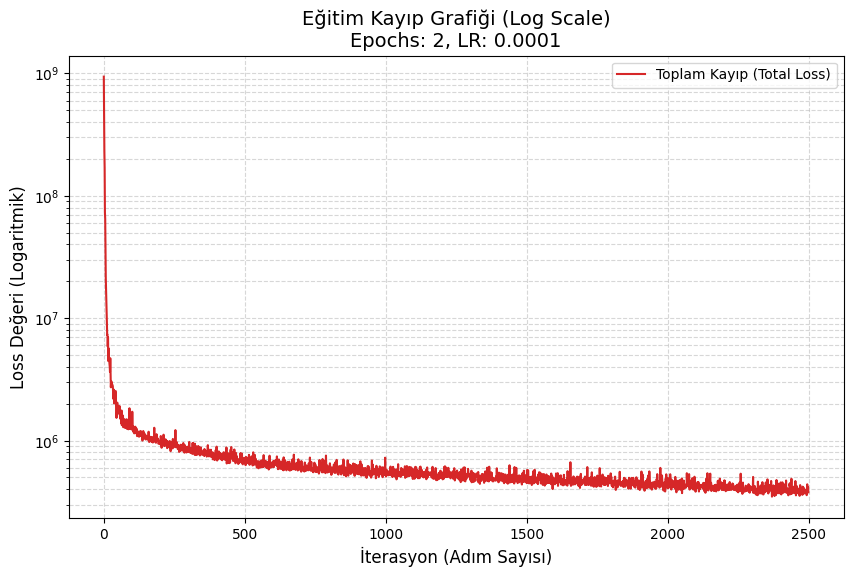

In [6]:
# --- 4. EĞİTİM DÖNGÜSÜ (OTOMATİK LOGARİTMİK GRAFİK) ---
import matplotlib.pyplot as plt  # Grafik kütüphanesi
import os

# 1. Modelleri Başlat
transformer = TransformerNet().to(DEVICE)
vgg = Vgg16().to(DEVICE)
optimizer = optim.Adam(transformer.parameters(), lr=LEARNING_RATE)
mse_loss = nn.MSELoss()

# 2. Stil Resmini Yükle
if not os.path.exists("style.jpg"):
    raise FileNotFoundError("❌ Lütfen 'style.jpg' dosyasını sol tarafa yükleyin!")

print("🎨 Stil resmi işleniyor...")
style_img = Image.open("style.jpg").convert('RGB')
style_tensor = transform(style_img).repeat(BATCH_SIZE, 1, 1, 1).to(DEVICE)

# Stil Özelliklerini Bir Kez Hesapla (Hız için)
features_style = vgg(normalize_batch(style_tensor))
gram_style = [gram_matrix(y) for y in features_style]

# --- KAYIP DEĞERLERİNİ TUTACAK LİSTE ---
loss_history = []

print(f"\n=== 🚀 EĞİTİM BAŞLIYOR (Toplam {EPOCHS} Epoch) ===")

for epoch in range(EPOCHS):
    transformer.train()
    for i, (x, _) in enumerate(train_loader):
        x = x.to(DEVICE)
        optimizer.zero_grad()

        # A. Tahmin
        y = transformer(x)

        # B. Özellik Çıkarımı
        y_norm = normalize_batch(y)
        x_norm = normalize_batch(x)
        fy = vgg(y_norm)
        fx = vgg(x_norm)

        # C. Kayıp Hesaplama (Loss)
        content_loss = CONTENT_WEIGHT * mse_loss(fy[1], fx[1])

        style_loss = 0.
        for ft_y, gm_s in zip(fy, gram_style):
            gm_y = gram_matrix(ft_y)
            style_loss += mse_loss(gm_y, gm_s[:BATCH_SIZE, :, :])
        style_loss *= STYLE_WEIGHT

        tv_loss = TV_WEIGHT * (torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) +
                               torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

        total_loss = content_loss + style_loss + tv_loss

        # --- DEĞERİ LİSTEYE EKLE ---
        loss_history.append(total_loss.item())

        # D. Geri Yayılım
        total_loss.backward()
        optimizer.step()

        # Loglama
        if (i+1) % 200 == 0:
            print(f"Epoch {epoch+1} | Adım {i+1} | Loss: {total_loss.item():.2f}")

# Modeli Kaydet
torch.save(transformer.state_dict(), "final_pro_model_v2.pth")
print("\n✅ EĞİTİM BİTTİ! Model kaydedildi.")

# --- YENİ: LOGARİTMİK GRAFİĞİ ÇİZ VE KAYDET ---
print("📊 Logaritmik grafik oluşturuluyor...")
plt.figure(figsize=(10, 6))

# Grafiği çiz
plt.plot(loss_history, label='Toplam Kayıp (Total Loss)', color='#d62728', linewidth=1.5)

# LOGARİTMİK AYAR
plt.yscale('log')

plt.title(f'Eğitim Kayıp Grafiği (Log Scale)\nEpochs: {EPOCHS}, LR: {LEARNING_RATE}', fontsize=14)
plt.xlabel('İterasyon (Adım Sayısı)', fontsize=12)
plt.ylabel('Loss Değeri (Logaritmik)', fontsize=12)
plt.grid(True, which="both", ls="--", alpha=0.5) # Detaylı ızgara çizgileri
plt.legend()

# Grafiği dosyaya kaydet
plt.savefig("egitim_log_grafigi.png", dpi=300)
print("✅ Grafik 'egitim_log_grafigi.png' olarak kaydedildi. Rapor için hazırdır!")
plt.show()

# 🎨 5. Gradio Arayüzü (Demo)

Eğitilen model (.pth dosyası), son kullanıcıların deneyimleyebilmesi için interaktif bir web arayüzüne dönüştürülür.

**-Inference Mode:** Model .eval() moduna alınarak eğitim özellikleri kapatılır.

**-Gradio:** Python tabanlı bu kütüphane sayesinde, kullanıcılar kendi fotoğraflarını yükleyip saniyeler içinde stilize edilmiş sonuçları görebilirler.

In [7]:
# --- 5. GRADIO ARAYÜZÜ ---
try:
    import gradio as gr
except ImportError:
    !pip install gradio
    import gradio as gr

def predict(image):
    # Modeli test moduna al
    transformer.eval()

    # Resmi Hazırla
    loader = transforms.Compose([
        transforms.Resize(512), # Çıktı boyutu
        transforms.ToTensor()
    ])
    image_tensor = loader(image).unsqueeze(0).to(DEVICE)

    # Tahmin Et
    with torch.no_grad():
        output = transformer(image_tensor)

    # Görselleştir
    output = output.cpu().squeeze(0).clamp(0, 1)
    return transforms.ToPILImage()(output)

# Arayüzü Başlat
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil", label="Orijinal Resim"),
    outputs=gr.Image(type="pil", label="Stilize Resim"),
    title="🎨 Yapay Zeka Stil Transferi",
    description="Yüklediğiniz fotoğrafı eğittiğimiz modelin sanat tarzına dönüştürür."
)

interface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://96dacc22b28fe4526a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://96dacc22b28fe4526a.gradio.live
